# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
bs = 1024
use_amp = True
lr = 1e-3

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import progress_bar

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

stty: 'standard input': Inappropriate ioctl for device


In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
train_df[train_df.fold==1].label.value_counts()

frog          1000
truck         1000
deer          1000
ship          1000
horse         1000
automobile    1000
dog           1000
cat           1000
airplane      1000
bird          1000
Name: label, dtype: int64

In [5]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [6]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=8, max_w_size=8, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


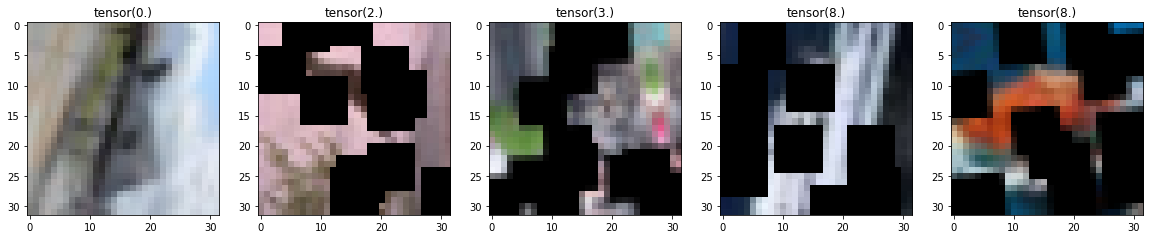

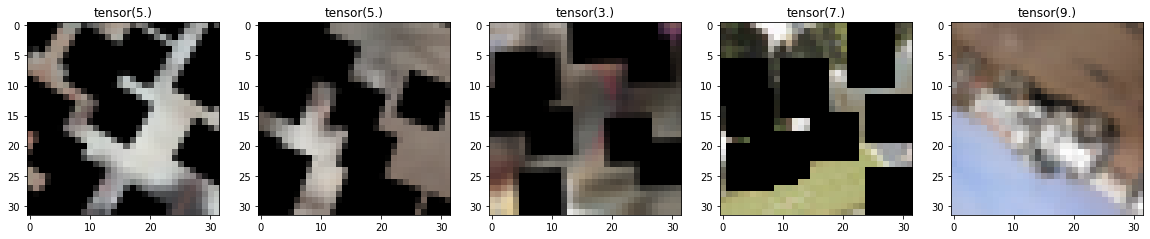

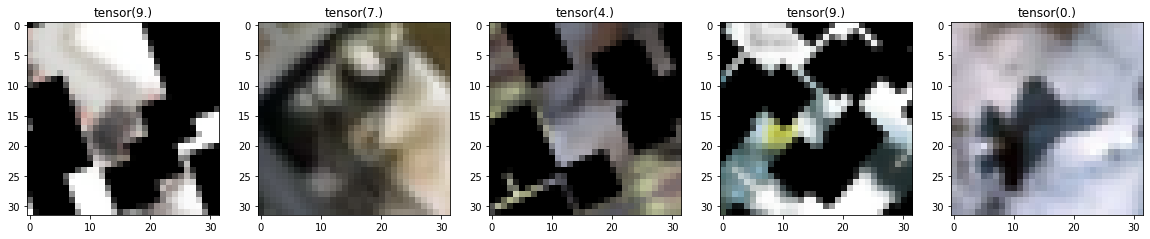

In [7]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [8]:
##### Training
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device).long()
        # Train with amp
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)

##### Validation
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device).long()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Save checkpoint.
    acc = 100.*correct/total
    return test_loss/(batch_idx+1), acc

In [11]:
# Data
print('==> Preparing data..')
from randomaug import RandAugment
import torchvision
import torchvision.transforms as transforms

size = imsize
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Add RandAugment with N, M(hyperparameter)
N = 2; M = 14;
transform_train.transforms.insert(0, RandAugment(N, M))

print('==> Preparing dataloader')
trainset = torchvision.datasets.CIFAR10(root='../vision-transformers-cifar10/data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='../vision-transformers-cifar10/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

==> Preparing data..
==> Preparing dataloader
Files already downloaded and verified
Files already downloaded and verified


In [12]:
from network.resnet import resnet20
net = resnet20(abits=8, wbits=8, pact=False, shallow=False)

abit/wbit: 8 8


In [13]:
net.forward(torch.randn(1,3,32,32))

tensor([[-0.2115,  0.0010,  0.4171, -0.5176,  0.3762,  0.2270,  0.5319,  0.7407,
          0.4683, -0.0782]], grad_fn=<AddmmBackward>)

# Train with quantization

from timm.scheduler import CosineLRScheduler

for shallow in [False]:
    for pact in [False,]:
        for k in range(3,9):
            net = resnet20(k,k,pact,shallow,True)

            net = net.cuda()
            mixup = False

            # Track experiment with wandb
            import wandb
            watermark = "resnet18_uniformquantize_k{}".format(k)
            if pact: watermark+="_pact"
            if shallow: 
                watermark+="_shallow"
            else:
                watermark+="_deep"
                
            # mess with wandb
            wandb.init(project="quantize_resnet2", name=watermark)

            # define loss function (criterion) and pptimizer
            criterion = nn.CrossEntropyLoss().cuda()

            # optimizer for pact
            optimizer = torch.optim.SGD(net.parameters(), lr=1e-3,
                                        momentum=0.9,
                                        weight_decay=0.0002)
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

            scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                                  warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

            best_prec1 = 0
            os.makedirs("models", exist_ok=True)

            for epoch in range(n_epochs):
                scheduler.step(epoch)
                # train for one epoch
                print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
                tloss = train(train_loader, model, criterion, optimizer, epoch)         

                # evaluate on validation set
                prec1, valloss = validate(val_loader, model, criterion)

                # wandb
                wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

                # remember best prec@1 and save checkpoint
                is_best = prec1 > best_prec1
                best_prec1 = max(prec1, best_prec1)

                print("Best prec1 : ", best_prec1)
                if is_best:
                    torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

In [14]:
from timm.scheduler import CosineLRScheduler
from network.resnet2 import ResNet18
device = "cuda"
shallow = False
#net = resnet20(8,8,False,shallow,True)
net = ResNet18()

net = net.cuda()
mixup = False

# Track experiment with wandb
import wandb
watermark = "resnet18_noquant"

if shallow: 
    watermark+="_shallow"
else:
    watermark+="_deep"

# mess with wandb
wandb.init(project="quantize_resnet2", name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

# optimizer for pact
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

list_loss = []
list_acc = []
    
net.cuda()
for epoch in range(n_epochs):
    start = time.time()
    trainloss = train(epoch)
    val_loss, prec1 = test(epoch)
    
    scheduler.step(epoch-1) # step cosine scheduling
    
    list_loss.append(val_loss)
    list_acc.append(prec1)
    
    # Log training..
    wandb.log({'epoch': epoch, 'train_loss': trainloss, 'val_loss': val_loss, "prec": prec1, "lr": optimizer.param_groups[0]["lr"],
    "epoch_time": time.time()-start})

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Best prec1 : ", best_prec1)
    if is_best:
        torch.save(net.state_dict(), os.path.join(f'models/{watermark}.pth'))

wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin



Epoch: 0
 [===============================================================>.]  Step: 269ms | Tot: 15s111ms | Loss: 2.257 | Acc: 17.066% (8533/5000 49/49 
 [================================================================>]  Step: 15ms | Tot: 1s599ms | Loss: 1.946 | Acc: 26.300% (2630/1000 100/100   Step: 16ms | Tot: 603ms | Loss: 1.943 | Acc: 27.000% (1026/380 38/10 41/100 42/100 46/10 47/100 ========================================>..............]  Step: 16ms | Tot: 1s243ms | Loss: 1.941 | Acc: 26.692% (2082/780 78/10 81/100 
Best prec1 :  26.3

Epoch: 1


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 [===============================================================>.]  Step: 270ms | Tot: 15s141ms | Loss: 2.005 | Acc: 24.134% (12067/5000 49/49 
 [================================================================>]  Step: 16ms | Tot: 1s579ms | Loss: 1.603 | Acc: 39.730% (3973/1000 100/100 ]  Step: 14ms | Tot: 390ms | Loss: 1.608 | Acc: 40.192% (1045/260 26/100 33/10 34/100 ==============>..........................................]  Step: 16ms | Tot: 527ms | Loss: 1.603 | Acc: 40.571% (1420/350 35/100 86/100 88/10 99/100 
Best prec1 :  39.73

Epoch: 2
 [===============================================================>.]  Step: 270ms | Tot: 15s297ms | Loss: 1.883 | Acc: 29.542% (14771/5000 49/49 
 [================================================================>]  Step: 14ms | Tot: 1s614ms | Loss: 1.522 | Acc: 43.780% (4378/1000 100/100 0 
Best prec1 :  43.78

Epoch: 3
 [===============================================================>.]  Step: 270ms | Tot: 15s280ms | Loss: 1.772 | Acc: 3

 [================================================================>]  Step: 14ms | Tot: 1s621ms | Loss: 0.541 | Acc: 81.080% (8108/1000 100/100  68/100 =====>.......]  Step: 14ms | Tot: 1s473ms | Loss: 0.546 | Acc: 80.867% (7278/900 90/100 ....]  Step: 16ms | Tot: 1s504ms | Loss: 0.543 | Acc: 80.989% (7451/920 92/10 93/100 
Best prec1 :  81.08

Epoch: 19
 [===============================================================>.]  Step: 275ms | Tot: 15s569ms | Loss: 1.095 | Acc: 59.554% (29777/5000 49/49 
 [================================================================>]  Step: 15ms | Tot: 1s658ms | Loss: 0.591 | Acc: 80.260% (8026/1000 100/100 ===========================================================>.]  Step: 16ms | Tot: 1s643ms | Loss: 0.592 | Acc: 80.212% (7941/990 99/100 
Best prec1 :  81.08

Epoch: 20
 [===============================================================>.]  Step: 278ms | Tot: 15s607ms | Loss: 1.083 | Acc: 59.934% (29967/5000 49/49 
 [=====================================

 [================================================================>]  Step: 14ms | Tot: 1s627ms | Loss: 0.355 | Acc: 87.990% (8799/1000 100/100 ..............]  Step: 16ms | Tot: 250ms | Loss: 0.337 | Acc: 88.375% (1414/160 16/100 =========>.....................................................]  Step: 17ms | Tot: 301ms | Loss: 0.343 | Acc: 88.316% (1678/190 19/100 ========================>........................................]  Step: 16ms | Tot: 611ms | Loss: 0.371 | Acc: 87.500% (3325/380 38/100 ==========================>......................................]  Step: 17ms | Tot: 679ms | Loss: 0.368 | Acc: 87.690% (3683/420 42/100 ==================================================>............]  Step: 14ms | Tot: 1s366ms | Loss: 0.358 | Acc: 87.902% (7208/820 82/100 ================================================>...........]  Step: 14ms | Tot: 1s381ms | Loss: 0.358 | Acc: 87.880% (7294/830 83/100 
Best prec1 :  87.99

Epoch: 35
 [==================================================

 [================================================================>]  Step: 16ms | Tot: 1s665ms | Loss: 0.333 | Acc: 88.740% (8874/1000 100/100 ...................................]  Step: 14ms | Tot: 278ms | Loss: 0.330 | Acc: 87.842% (1669/190 19/10 44/100 
Best prec1 :  89.99

Epoch: 51
 [===============================================================>.]  Step: 275ms | Tot: 15s584ms | Loss: 0.868 | Acc: 67.392% (33696/5000 49/49 
 [================================================================>]  Step: 15ms | Tot: 1s610ms | Loss: 0.358 | Acc: 88.790% (8879/1000 100/100 
Best prec1 :  89.99

Epoch: 52
 [===============================================================>.]  Step: 277ms | Tot: 15s586ms | Loss: 0.871 | Acc: 67.374% (33687/5000 49/49 
 [================================================================>]  Step: 16ms | Tot: 1s677ms | Loss: 0.321 | Acc: 89.500% (8950/1000 100/100 =========================>...................................]  Step: 16ms | Tot: 746ms | Loss: 0.

 [================================================================>]  Step: 15ms | Tot: 1s634ms | Loss: 0.312 | Acc: 90.260% (9026/1000 100/100  17/100 18/10 19/100 25/100 26/100 30/100 ...........]  Step: 19ms | Tot: 579ms | Loss: 0.322 | Acc: 89.784% (3322/370 37/100 
Best prec1 :  91.3

Epoch: 67
 [===============================================================>.]  Step: 274ms | Tot: 15s581ms | Loss: 0.823 | Acc: 68.986% (34493/5000 49/49 
 [================================================================>]  Step: 16ms | Tot: 1s638ms | Loss: 0.288 | Acc: 91.050% (9105/1000 100/100 ....................]  Step: 16ms | Tot: 315ms | Loss: 0.292 | Acc: 90.857% (1908/210 21/100 =============================================>...................]  Step: 15ms | Tot: 1s143ms | Loss: 0.297 | Acc: 90.972% (6459/710 71/100 ]  Step: 18ms | Tot: 1s328ms | Loss: 0.293 | Acc: 91.098% (7470/820 82/100 ================================>...........]  Step: 17ms | Tot: 1s362ms | Loss: 0.291 | Acc: 91.095%

 [===============================================================>.]  Step: 276ms | Tot: 15s609ms | Loss: 0.779 | Acc: 70.278% (35139/5000 49/49 
 [================================================================>]  Step: 40ms | Tot: 1s650ms | Loss: 0.270 | Acc: 92.030% (9203/1000 100/100 0 ======================================>........................]  Step: 18ms | Tot: 1s42ms | Loss: 0.275 | Acc: 91.891% (5881/640 64/100 ===================================================>...........]  Step: 17ms | Tot: 1s355ms | Loss: 0.269 | Acc: 91.928% (7630/830 83/10 99/100 
Best prec1 :  92.1

Epoch: 83
 [===============================================================>.]  Step: 276ms | Tot: 15s645ms | Loss: 0.781 | Acc: 70.506% (35253/5000 49/49 
 [================================================================>]  Step: 15ms | Tot: 1s620ms | Loss: 0.286 | Acc: 91.580% (9158/1000 100/100 100 71/100 
Best prec1 :  92.1

Epoch: 84
 [==============================================================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 35ms | Tot: 1s648ms | Loss: 0.236 | Acc: 94.350% (9435/1000 100/100 
Best prec1 :  94.39

Epoch: 178
 [===============================================================>.]  Step: 275ms | Tot: 15s622ms | Loss: 0.672 | Acc: 74.108% (37054/5000 49/49 
 [================================================================>]  Step: 14ms | Tot: 1s612ms | Loss: 0.236 | Acc: 94.310% (9431/1000 100/100 
Best prec1 :  94.39

Epoch: 179
 [===============================================================>.]  Step: 276ms | Tot: 15s601ms | Loss: 0.670 | Acc: 74.344% (37172/5000 49/49 
 [================================================================>]  Step: 16ms | Tot: 1s636ms | Loss: 0.233 | Acc: 94.450% (9445/1000 100/100 0 =====================================================>...........]  Step: 15ms | Tot: 1s361ms | Loss: 0.235 | Acc: 94.500% (7938/840 84/10 92/100 99/100 
Best prec1 :  94.45

Epoch: 180
 [====================

 [================================================================>]  Step: 16ms | Tot: 1s640ms | Loss: 0.232 | Acc: 94.500% (9450/1000 100/100 0 29/100 60/100 61/10 79/100 
Best prec1 :  94.51

Epoch: 197
 [===============================================================>.]  Step: 272ms | Tot: 15s583ms | Loss: 0.652 | Acc: 75.022% (37511/5000 49/49 


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from timm.scheduler import CosineLRScheduler
from network.resnet2 import ResNet18
device = "cuda"
shallow = True
net = resnet20(8,8,False,shallow,True)

net = net.cuda()
mixup = False

# Track experiment with wandb
import wandb
watermark = "resnet20_noquant"

if shallow: 
    watermark+="_shallow"
else:
    watermark+="_deep"

# mess with wandb
wandb.init(project="quantize_resnet2", name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

# optimizer for pact
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

list_loss = []
list_acc = []
    
net.cuda()
for epoch in range(n_epochs):
    start = time.time()
    trainloss = train(epoch)
    val_loss, prec1 = test(epoch)
    
    scheduler.step(epoch-1) # step cosine scheduling
    
    list_loss.append(val_loss)
    list_acc.append(prec1)
    
    # Log training..
    wandb.log({'epoch': epoch, 'train_loss': trainloss, 'val_loss': val_loss, "prec": prec1, "lr": optimizer.param_groups[0]["lr"],
    "epoch_time": time.time()-start})

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Best prec1 : ", best_prec1)
    if is_best:
        torch.save(net.state_dict(), os.path.join(f'models/{watermark}.pth'))

abit/wbit: 8 8


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▁▂▂▅▄▄▂▅▃▂▅▅▆▆▄▅▅▆▅▅▅▄▇▆▆▄▆▆▄▇▆▇▆▆▃▆█▄█▄
lr,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
prec,▁▃▆▆▆▆▇▇▇▇▇▇████████████████████████████
train_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
epoch_time,26.07594
lr,0.0
prec,94.28
train_loss,0.66844



Epoch: 0
 [===============================================================>.]  Step: 153ms | Tot: 8s405ms | Loss: 2.164 | Acc: 18.754% (9377/5000 49/49 
 [================================================================>]  Step: 9ms | Tot: 929ms | Loss: 2.085 | Acc: 26.420% (2642/1000 100/100 10 23/10 30/100 ...................]  Step: 10ms | Tot: 539ms | Loss: 2.092 | Acc: 26.322% (1553/590 59/100 .]  Step: 10ms | Tot: 633ms | Loss: 2.095 | Acc: 26.129% (1829/700 70/100 
Best prec1 :  26.42

Epoch: 1


/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 [===============================================================>.]  Step: 155ms | Tot: 8s346ms | Loss: 1.964 | Acc: 26.124% (13062/5000 49/49 
 [================================================================>]  Step: 7ms | Tot: 945ms | Loss: 1.631 | Acc: 39.280% (3928/1000 100/100 /100 ===========================================>.................]  Step: 8ms | Tot: 719ms | Loss: 1.632 | Acc: 39.351% (2912/740 74/100 
Best prec1 :  39.28

Epoch: 2
 [===============================================================>.]  Step: 145ms | Tot: 8s382ms | Loss: 1.847 | Acc: 31.026% (15513/5000 49/49 
 [================================================================>]  Step: 8ms | Tot: 957ms | Loss: 1.539 | Acc: 45.540% (4554/1000 100/100 =====================>..........................................]  Step: 9ms | Tot: 330ms | Loss: 1.533 | Acc: 45.029% (1576/350 35/100 ==============================================>..................]  Step: 11ms | Tot: 667ms | Loss: 1.529 | Acc: 45.764% (3

 [================================================================>]  Step: 8ms | Tot: 962ms | Loss: 1.121 | Acc: 63.100% (6310/100099/100  24/10 25/100 26/100 30/100 32/100 33/10 43/100 ============================>....................................]  Step: 7ms | Tot: 441ms | Loss: 1.115 | Acc: 63.689% (2866/450 45/100 46/100 ==============================>..................................]  Step: 9ms | Tot: 466ms | Loss: 1.120 | Acc: 63.479% (3047/480 48/100 60/100  62/10 69/100 =============>...........]  Step: 8ms | Tot: 777ms | Loss: 1.117 | Acc: 63.301% (5254/830 83/10 86/10 87/100 ========================================================>........]  Step: 9ms | Tot: 819ms | Loss: 1.124 | Acc: 63.000% (5544/880 88/100 89/10 90/100 91/100 92/100 94/10 100/100 
Best prec1 :  70.14

Epoch: 17
 [===============================================================>.]  Step: 157ms | Tot: 8s515ms | Loss: 1.279 | Acc: 53.204% (26602/5000 49/49 ...]  Step: 198ms | Tot: 201ms | Loss: 1.285 | A

 [================================================================>]  Step: 7ms | Tot: 967ms | Loss: 0.603 | Acc: 79.110% (7911/1000 100/100 9/100 ===================================>...........................]  Step: 7ms | Tot: 557ms | Loss: 0.604 | Acc: 79.153% (4670/590 59/100 
Best prec1 :  79.62

Epoch: 31
 [===============================================================>.]  Step: 147ms | Tot: 8s543ms | Loss: 1.168 | Acc: 56.950% (28475/5000 49/49 
 [================================================================>]  Step: 7ms | Tot: 927ms | Loss: 0.667 | Acc: 78.070% (7807/1000 100/100 0/100 ...]  Step: 12ms | Tot: 509ms | Loss: 0.675 | Acc: 77.941% (3975/510 51/10 66/100 ==============================================>................]  Step: 7ms | Tot: 727ms | Loss: 0.668 | Acc: 77.921% (5922/760 76/100 90/100 ===========================================================>.....]  Step: 7ms | Tot: 864ms | Loss: 0.668 | Acc: 78.011% (7177/920 92/100 
Best prec1 :  79.62

Epoch: 32
 

 [================================================================>]  Step: 8ms | Tot: 915ms | Loss: 0.612 | Acc: 79.710% (7971/100009/100  4/100 37/100 43/100 =========>.....................................]  Step: 7ms | Tot: 378ms | Loss: 0.614 | Acc: 79.818% (3512/440 44/100 ..............................]  Step: 6ms | Tot: 384ms | Loss: 0.611 | Acc: 80.000% (3600/450 45/100 ========================>...................................]  Step: 8ms | Tot: 405ms | Loss: 0.614 | Acc: 79.957% (3758/470 47/100 62/100 ...............]  Step: 8ms | Tot: 560ms | Loss: 0.615 | Acc: 79.862% (5191/650 65/100 66/10 67/100 ...]  Step: 12ms | Tot: 685ms | Loss: 0.611 | Acc: 80.027% (5922/740 74/10 80/10 94/100 100/100 
Best prec1 :  79.91

Epoch: 44
 [===============================================================>.]  Step: 155ms | Tot: 8s508ms | Loss: 1.106 | Acc: 59.134% (29567/5000 49/49 
 [================================================================>]  Step: 9ms | Tot: 982ms | Loss: 0.541 

 [===============================================================>.]  Step: 147ms | Tot: 8s546ms | Loss: 1.057 | Acc: 61.092% (30546/5000 49/49 
 [================================================================>]  Step: 7ms | Tot: 979ms | Loss: 0.524 | Acc: 82.160% (8216/1000 100/100 /100 27/100 =================>...............................................]  Step: 8ms | Tot: 266ms | Loss: 0.543 | Acc: 81.821% (2291/280 28/100 =========================>.......................................]  Step: 7ms | Tot: 401ms | Loss: 0.542 | Acc: 82.250% (3290/400 40/100 42/100 43/100 44/10 49/100 50/100 51/100 67/100 ================================================>................]  Step: 7ms | Tot: 747ms | Loss: 0.523 | Acc: 82.461% (6267/760 76/100 ========================================================>......]  Step: 8ms | Tot: 912ms | Loss: 0.528 | Acc: 82.099% (7471/910 91/100 
Best prec1 :  82.82

Epoch: 57
 [===============================================================>.]  Step: 

 [================================================================>]  Step: 7ms | Tot: 925ms | Loss: 0.429 | Acc: 85.500% (8550/1000 100/100 ======================>.........................................]  Step: 7ms | Tot: 331ms | Loss: 0.446 | Acc: 85.054% (3147/370 37/100  52/100 57/100 ==============================================>................]  Step: 6ms | Tot: 725ms | Loss: 0.434 | Acc: 85.553% (6502/760 76/100 
Best prec1 :  85.5

Epoch: 70
 [===============================================================>.]  Step: 147ms | Tot: 8s538ms | Loss: 1.022 | Acc: 62.096% (31048/5000 49/49 
 [================================================================>]  Step: 8ms | Tot: 961ms | Loss: 0.470 | Acc: 84.230% (8423/1000 100/100 =========================================>....................]  Step: 8ms | Tot: 696ms | Loss: 0.481 | Acc: 83.814% (5867/700 70/10 72/100 =======================================================>.........]  Step: 9ms | Tot: 852ms | Loss: 0.477 | Acc: 83.8